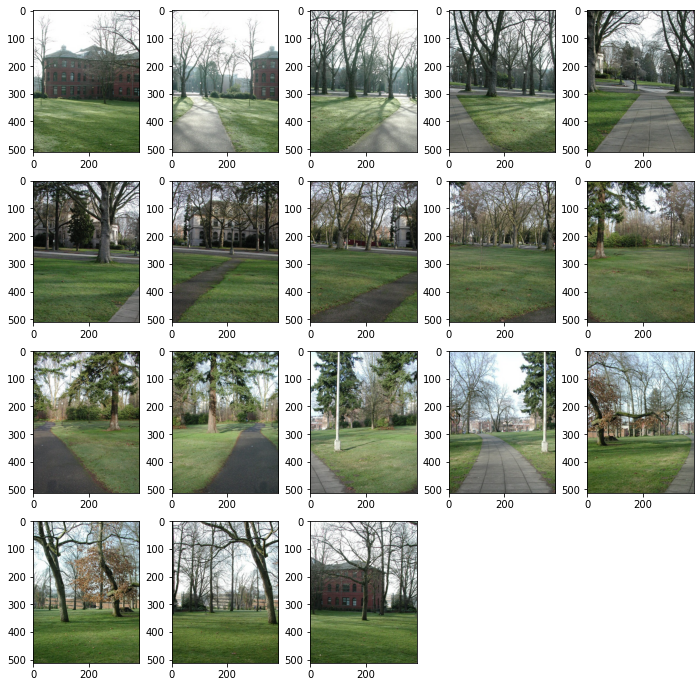

In [39]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

focal_len = 705
path = "./data/parrington/prtn*.jpg"
files = glob.glob(path)
files.sort(reverse=False)
images = [cv2.imread(f) for f in files]

plt.figure(figsize=(12,12))
for i in range(len(images)):
    plt.subplot(4, math.ceil(len(images)/4), i+1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))

In [50]:
def warp(image):
    result_width = round(math.atan(image.shape[1]/2/focal_len) * focal_len * 2)
    result_height = image.shape[0]
    origin_center_x = image.shape[1] // 2
    origin_center_y = image.shape[0] // 2

    result_center_x = result_width // 2
    result_center_y = result_height // 2

    print(result_width, result_height)

    def project_pixel(i, j):
        theta = i - result_center_x
        h = j - result_center_y

        print(i)
        # print(origin_center_x)
        x = round(focal_len * math.tan(theta) + origin_center_x)
        y = round(h / math.cos(theta) + origin_center_y)
        try:
            return image[x][y]
        except:
            return np.zeros(3)

    return np.fromfunction(lambda i, j: project_pixel(i, j), (result_width, result_height), dtype=int)




In [51]:
result_images = [warp(img) for img in images]

plt.clf()
plt.figure(figsize=(12,12))
for i in range(len(result_images)):
    plt.subplot(4, math.ceil(len(result_images)/4), i+1)
    plt.imshow(cv2.cvtColor(result_images[i], cv2.COLOR_BGR2RGB))

375 512
[[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [372 372 372 ... 372 372 372]
 [373 373 373 ... 373 373 373]
 [374 374 374 ... 374 374 374]]


TypeError: only size-1 arrays can be converted to Python scalars

In [45]:
np.fromfunction(lambda i, j: i , (3, 3), dtype=int)

array([[0, 0, 0],
       [1, 1, 1],
       [2, 2, 2]])